In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np

In [2]:
def plot_func(models, ylim_spearman=[0.53, 0.87], ylim_pearson=None):
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))

    for x in models:
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                spearman, pearson = [], []
                std_spearman, std_pearson = [], []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))

                    std_1 = res["stdev_cosine_spearman_test"]
                    mean_1 = res["mean_cosine_spearman_test"]
                    std_spearman.append((mean_1-std_1, mean_1+std_1))
                    spearman.append(mean_1)

                    std_2 = res["stdev_cosine_pearson_test"]
                    mean_2 = res["mean_cosine_pearson_test"]
                    std_pearson.append((mean_2-std_2, mean_2+std_2))
                    pearson.append(mean_2)

                axs[0].plot(spearman, label=label)
                if "unsupervised" not in name:
                    axs[0].fill_between(
                        np.array(list(range(c))), 
                        np.array(std_spearman)[:,0], 
                        np.array(std_spearman)[:,1], 
                        alpha=0.15
                    )
                axs[0].set_xlabel("Index of used hidden state")
                axs[0].set_ylabel("Spearman correlation coefficient (test set)")
                axs[0].legend()
                if ylim_spearman is not None:
                    axs[0].set_ylim(ylim_spearman)

                axs[1].plot(pearson, label=label)
                if "unsupervised" not in name:
                    axs[1].fill_between(
                        np.array(list(range(c))), 
                        np.array(std_pearson)[:,0], 
                        np.array(std_pearson)[:,1], 
                        alpha=0.15
                    )
                axs[1].set_xlabel("Index of used hidden state")
                axs[1].set_ylabel("Pearson correlation coefficient (test set)")
                axs[1].legend()
                if ylim_pearson is not None:
                    axs[1].set_ylim(ylim_pearson)
                
def plot_func_unsupervised(models):
    fig, axs = plt.subplots(2, 1, figsize=(8, 16))

    for x in models:
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names = x[3]
        for p in pool:
            spearman, pearson = [], []
            spearman_std, pearson_std = [], []
            for name in json_names:
                spearman_tmp, pearson_tmp = [], []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))

                    mean_1 = res["mean_cosine_spearman_test"]
                    spearman_tmp.append(mean_1)

                    mean_2 = res["mean_cosine_pearson_test"]
                    pearson_tmp.append(mean_2)
                
                spearman.append(spearman_tmp)
                pearson.append(pearson_tmp)
                
            spearman = np.array(spearman)
            pearson = np.array(pearson)
            
            spearman_mean = spearman.mean(axis=0)
            pearson_mean = pearson.mean(axis=0)
            
            spearman_std = spearman.std(axis=0, ddof=1)
            pearson_std = pearson.std(axis=0, ddof=1)

            axs[0].plot(spearman_mean, label=f"{m} {p}")
            if "unsupervised" in name:
                axs[0].fill_between(
                    np.array(list(range(c))), 
                    spearman_mean - spearman_std,
                    spearman_mean + spearman_std, 
                    alpha=0.15
                )
            axs[0].set_xlabel("Index of finetuned hidden state")
            axs[0].set_ylabel("Spearman correlation coefficient (test set)")
            axs[0].legend()

            axs[1].plot(pearson_mean, label=f"{m} {p}")
            if "unsupervised" in name:
                axs[1].fill_between(
                    np.array(list(range(c))), 
                    pearson_mean - pearson_std,
                    pearson_mean + pearson_std, 
                    alpha=0.15
                )
            axs[1].set_xlabel("Index of hidden state")
            axs[1].set_ylabel("Pearson correlation coefficient (test set)")
            axs[1].legend()

# Finetuned

### Word Sim

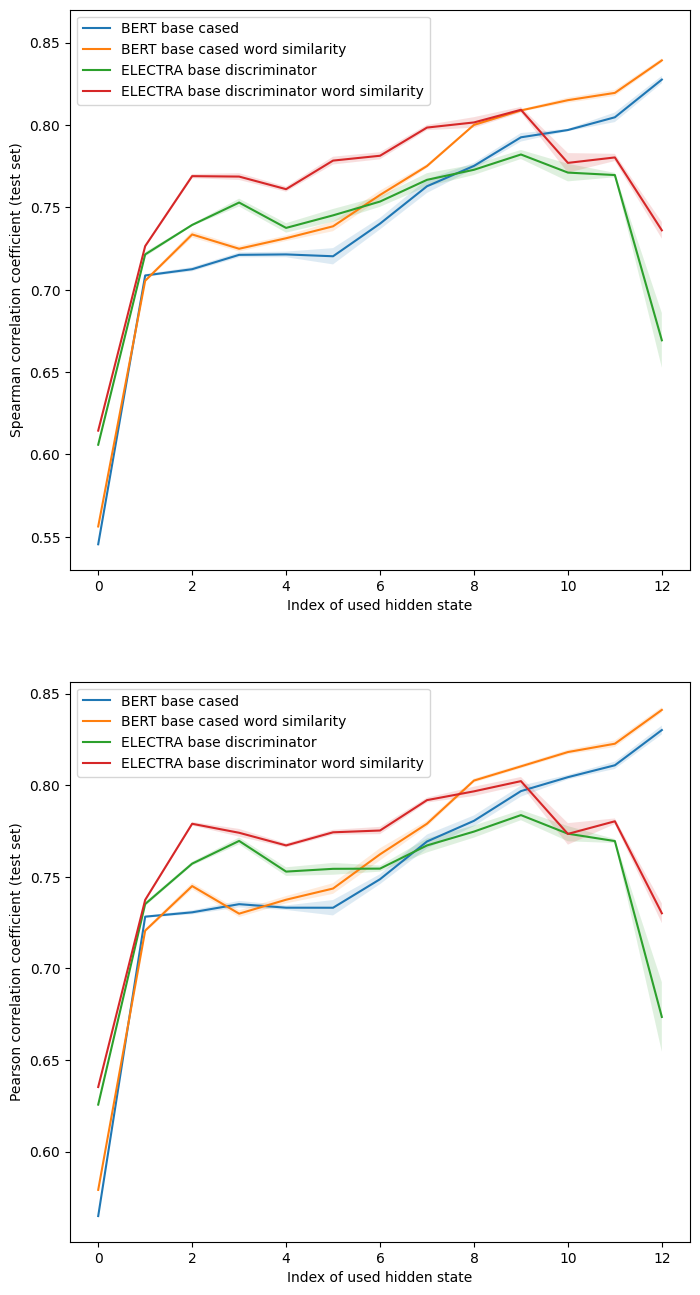

In [3]:
models = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
            ("test_results_word_similarity", "BERT base cased word similarity")
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base discriminator"),
            ("test_results_word_similarity", "ELECTRA base discriminator word similarity")
         ]
    ),
    #("google-electra-base-generator", ["mean"], 13, 
    #     [
    #        ("test_results", "ELECTRA base generator"),
    #        ("test_results_word_similarity", "ELECTRA base generator word similarity")
    #     ]
    #)
]

plot_func(models)

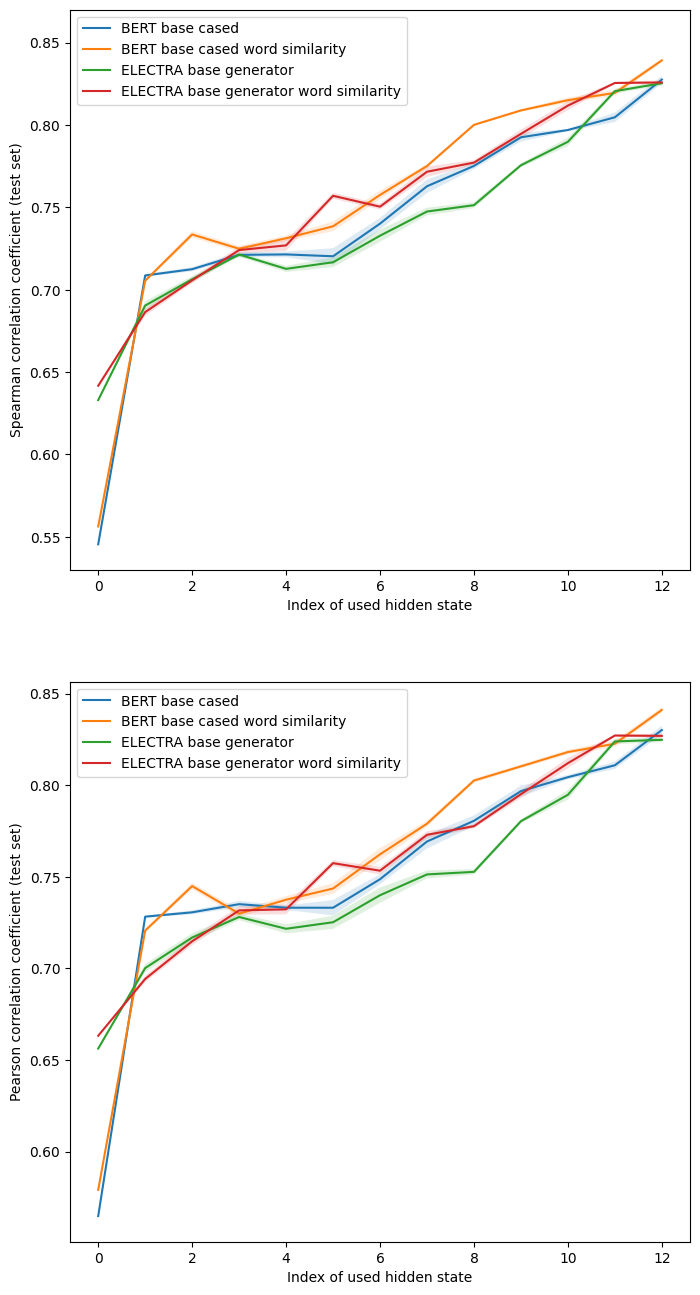

In [4]:
models = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
            ("test_results_word_similarity", "BERT base cased word similarity")
         ]
    ),
    #("google-electra-base-discriminator", ["mean"], 13, 
    #     [
    #        ("test_results", "ELECTRA base discriminator"),
    #        ("test_results_word_similarity", "ELECTRA base discriminator word similarity")
    #     ]
    #),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base generator"),
            ("test_results_word_similarity", "ELECTRA base generator word similarity")
         ]
    )
]

plot_func(models)

### Standard

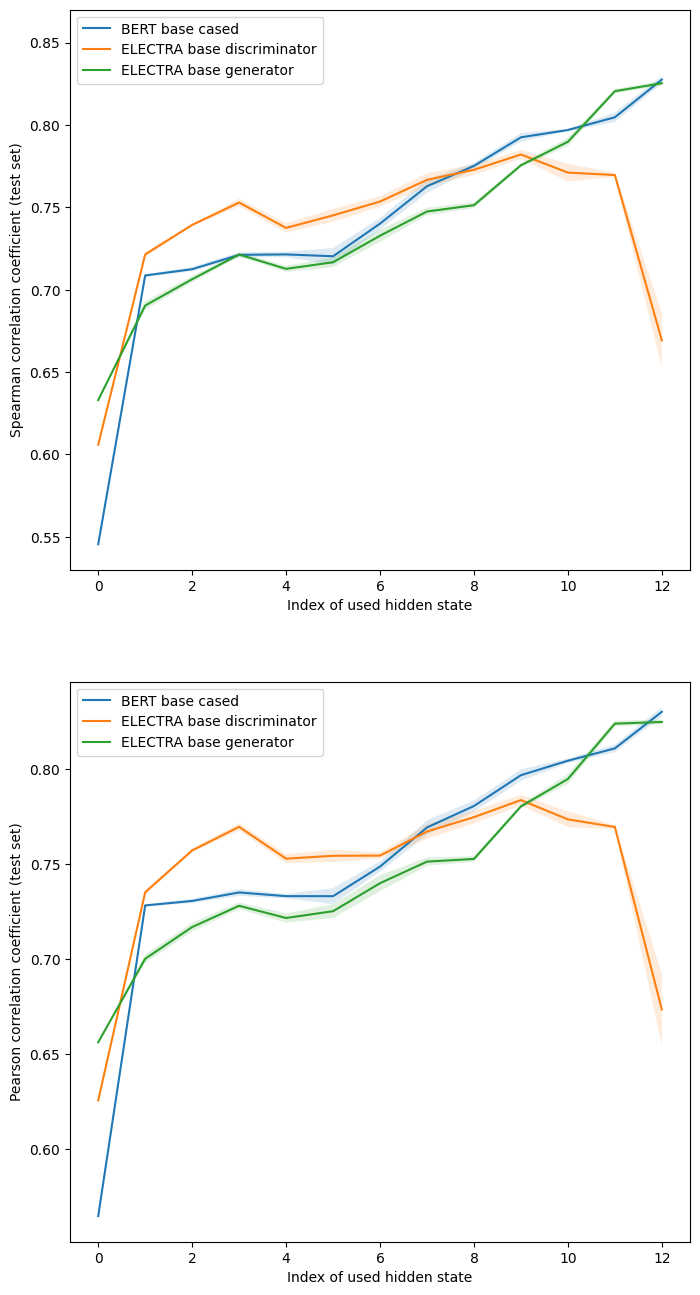

In [5]:
models = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
        [
            ("test_results", "ELECTRA base generator"),
         ]
    )
]

plot_func(models)

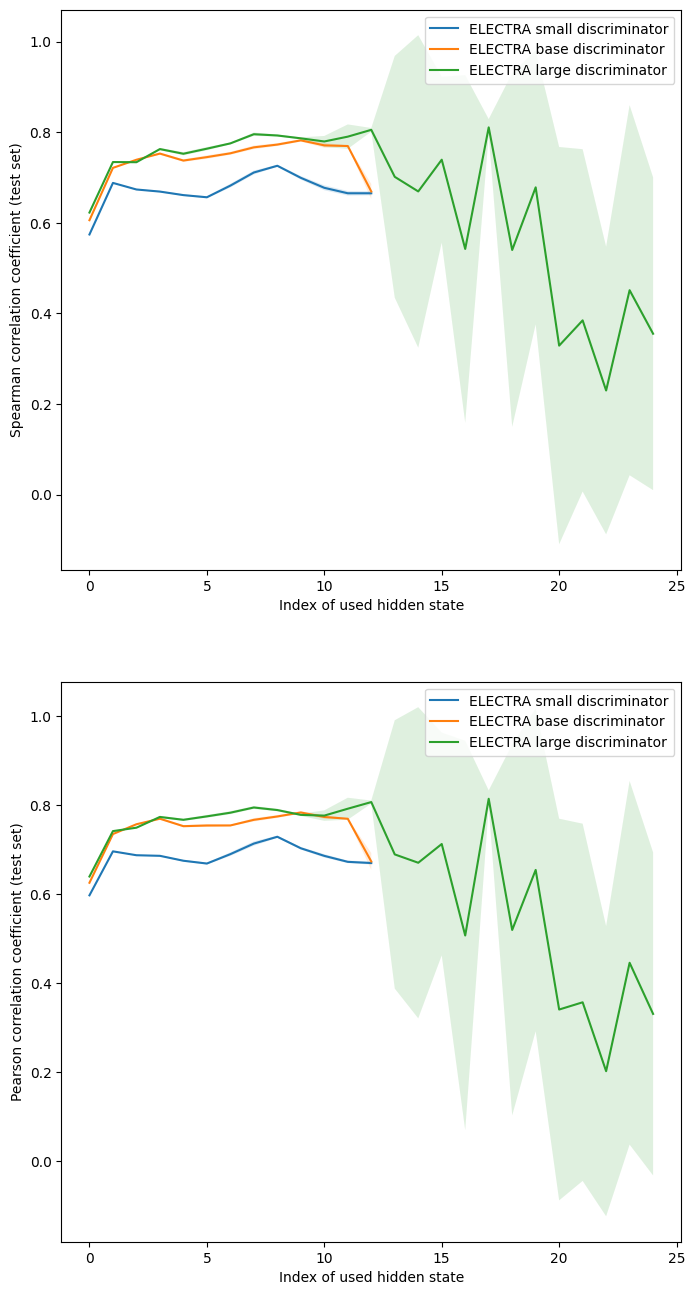

In [6]:
models = [
    ("google-electra-small-discriminator", ["mean"], 13,
         [
            ("test_results", "ELECTRA small discriminator"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13,
         [
            ("test_results", "ELECTRA base discriminator"),
         ]
    ),
    ("google-electra-large-discriminator", ["mean"], 25,
        [
            ("test_results", "ELECTRA large discriminator"),
         ]
    )
]

plot_func(models, ylim_spearman=None)

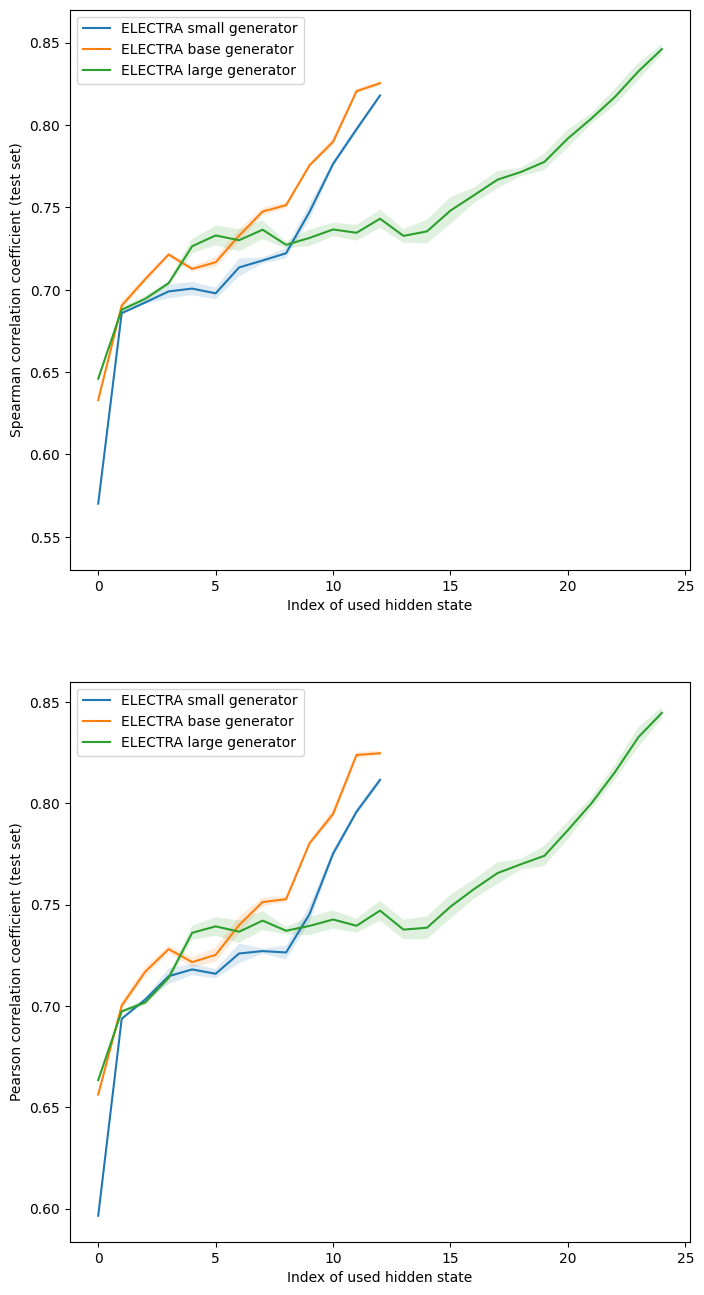

In [7]:
models = [
    ("google-electra-small-generator", ["mean"], 13,
         [
            ("test_results", "ELECTRA small generator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13,
         [
            ("test_results", "ELECTRA base generator"),
         ]
    ),
    ("google-electra-large-generator", ["mean"], 25,
        [
            ("test_results", "ELECTRA large generator"),
         ]
    )
]

plot_func(models)

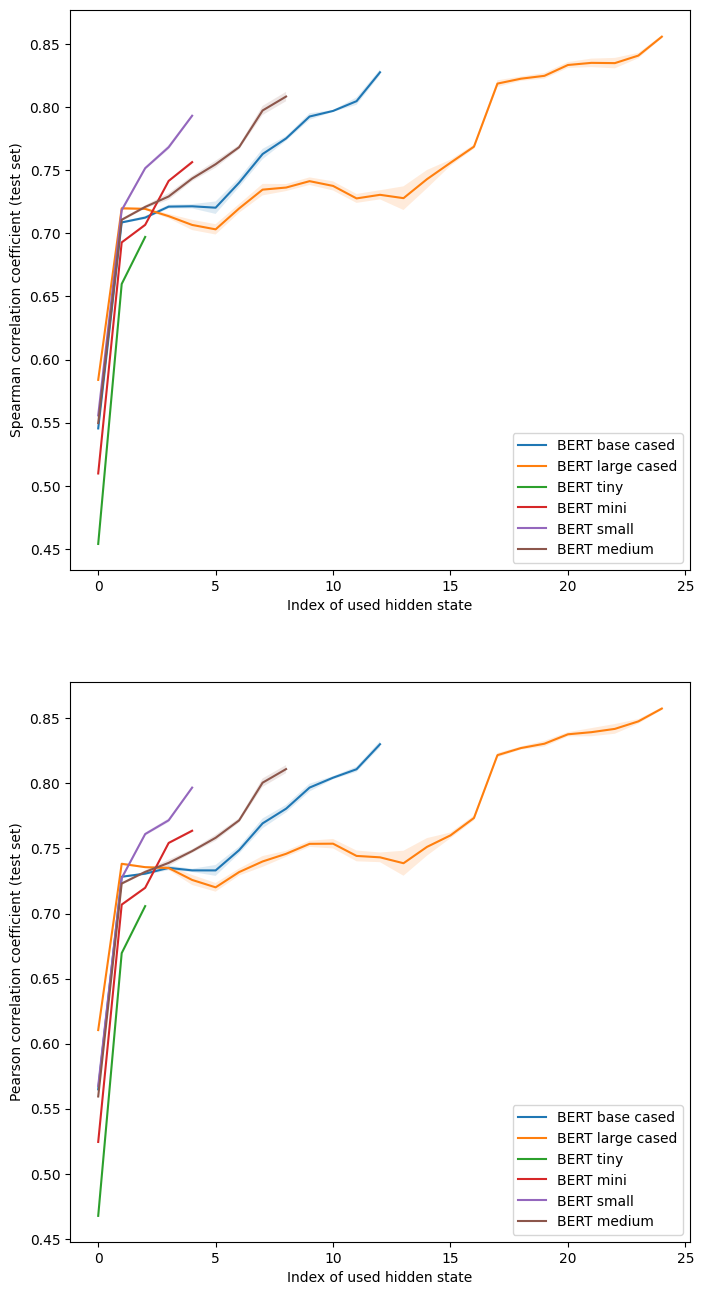

In [8]:
models = [
    
    ("bert-base-cased", ["mean"], 13,
         [
            ("test_results", "BERT base cased"),
         ]
    ),
    ("bert-large-cased", ["mean"], 25,
         [
            ("test_results", "BERT large cased"),
         ]
    ),
    ("google-bert_uncased_L-2_H-128_A-2", ["mean"], 3,
        [
            ("test_results", "BERT tiny"),
         ]
    ),
    ("google-bert_uncased_L-4_H-256_A-4", ["mean"], 5,
        [
            ("test_results", "BERT mini"),
         ]
    ),
    ("google-bert_uncased_L-4_H-512_A-8", ["mean"], 5,
        [
            ("test_results", "BERT small"),
         ]
    ),
    ("google-bert_uncased_L-8_H-512_A-8", ["mean"], 9,
        [
            ("test_results", "BERT medium"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]


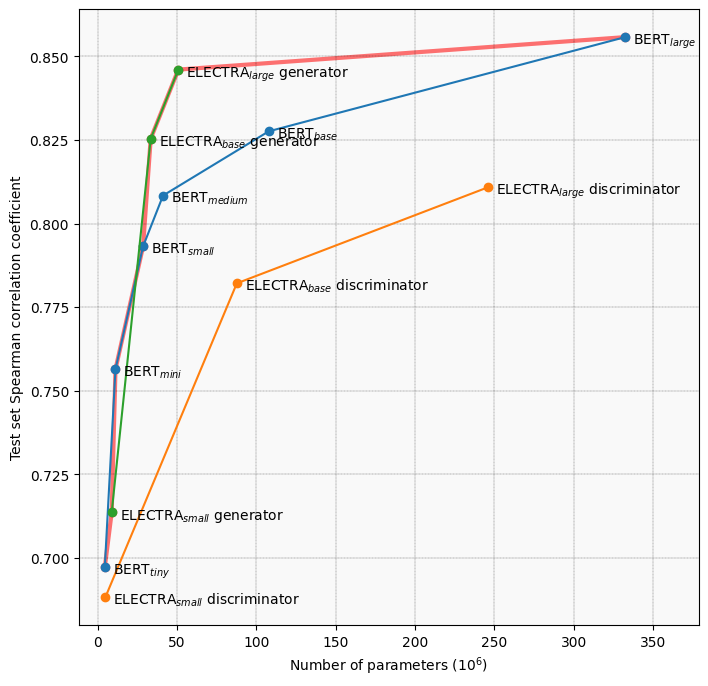

In [9]:
from transformers import AutoModel
from tqdm import tqdm
import torch

models = [
    [
        ("bert-base-cased", 13, "BERT$_{base}$"),
        ("bert-large-cased", 25, "BERT$_{large}$"),
        ("google-bert_uncased_L-8_H-512_A-8", 9, "BERT$_{medium}$"),
        ("google-bert_uncased_L-4_H-512_A-8", 5,"BERT$_{small}$"),
        ("google-bert_uncased_L-2_H-128_A-2", 3,"BERT$_{tiny}$"),
        ("google-bert_uncased_L-4_H-256_A-4", 5,"BERT$_{mini}$"),
    ],
    [
        ("google-electra-small-discriminator", 7, "ELECTRA$_{small}$ discriminator"),
        ("google-electra-base-discriminator", 13, "ELECTRA$_{base}$ discriminator"),
        ("google-electra-large-discriminator", 25, "ELECTRA$_{large}$ discriminator"),
    ],
    [
        ("google-electra-small-generator", 7, "ELECTRA$_{small}$ generator"),
        ("google-electra-base-generator", 13, "ELECTRA$_{base}$ generator"),
        ("google-electra-large-generator", 25, "ELECTRA$_{large}$ generator"),

    ]
]


def count_params(model, i):
    x = torch.tensor(0.)
    for p in model.embeddings.parameters():
        x += torch.prod(torch.tensor(p.shape))
    if i > 0:
        for p in model.encoder.layer[:i].parameters():
            x += torch.prod(torch.tensor(p.shape))
    return x/10**6

all_scores_params = []
plt.figure(figsize=(8, 8))
ax = plt.gca()
for f in models:
    spearman, parameters = [], []
    for m in tqdm(f):
        means = []
        name = m[0] if "google" not in m[0] else m[0].replace("google-", "google/")
        model = AutoModel.from_pretrained(name)
        for i in range(m[1]):
            params = count_params(model, i)
            res = json.load(open(f"../output/{m[0]}/mean/{i}_to_{i+1}/test_results.json"))
            means.append([res["mean_cosine_spearman_test"], params])
        #print(np.array(means))
        means = np.array(sorted(means, key=lambda x: x[0]))
        x, y = means[::-1, :][0]
        all_scores_params.append([x, y])
        spearman.append(x)
        parameters.append(y)
        plt.annotate(m[2], (y+5, x-0.002))
        
    means_ = np.array([spearman, parameters]).T
    means_.sort(axis=0)
    
    plt.plot(means_[:,1], means_[:,0], "-o")
    plt.xlim([plt.xlim()[0], plt.xlim()[1]+10])
    plt.xlabel("Number of parameters ($10^6$)")
    plt.ylabel("Test set Spearman correlation coefficient")
ax.set_facecolor("#F9F9F9")
ax.grid(color='black', linestyle='--', linewidth=0.2)


def pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, (x, y) in enumerate(points):
        for j, (x_other, y_other) in enumerate(points):
            if i != j:
                if x_other <= x and y_other >= y:
                    mask[i] = False
                    break 
    return mask

all_scores_params = np.array(all_scores_params)
all_scores_params[:,[0,1]] = all_scores_params[:,[1,0]]
pareto = all_scores_params[pareto_front(all_scores_params)].tolist()
pareto = np.array(sorted(pareto, key=lambda x: (x[0], x[1])))
plt.plot(pareto[:,0], pareto[:, 1], "-o", color="r", alpha=0.55, linewidth=3, zorder=0)

plt.show()

In [10]:
def count_params(model, i):
    x = torch.tensor(0.)
    for p in model.parameters():
        x += torch.prod(torch.tensor(p.shape))
    return x/10**6

count_params(model, 25)
model.config

ElectraConfig {
  "_name_or_path": "google/electra-large-generator",
  "architectures": [
    "ElectraForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 1024,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

# Korean

In [ ]:
models = [
    ("klue-bert-base", ["mean"], 13, 
        [
            ("test_results_kor_sts", "KLUE BERT base"),
         ]
    ),
    ("monologg-koelectra-base-v3-generator", ["mean"], 13, 
        [
            ("test_results_kor_sts", "KoELECTRA generator base"),
         ]
    ),
    ("monologg-koelectra-base-v3-discriminator", ["mean"], 13,
        [
            ("test_results_kor_sts", "KoELECTRA discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

# German

In [ ]:
models = [
    ("bert-base-german-cased", ["mean"], 13,
        [
            ("test_results_german_sts", "BERT base german cased"),
         ]
    ),
    ("deepset-gelectra-base-generator", ["mean"], 13, 
        [
            ("test_results_german_sts", "GELECTRA generator base"),
         ]
    ),
    ("deepset-gelectra-base", ["mean"], 13, 
        [
            ("test_results_german_sts", "GELECTRA discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

# Spanish

In [ ]:
models = [
    ("dccuchile-bert-base-spanish-wwm-cased", ["mean"], 13, 
        [
            ("test_results_spanish_sts", "BETO base"),
         ]
    ),
    ("mrm8488-electricidad-base-generator", ["mean"], 13, 
        [
            ("test_results_spanish_sts", "Electricidad generator base"),
         ]
    ),
    ("mrm8488-electricidad-base-discriminator", ["mean"], 13, 
        [
            ("test_results_spanish_sts", "Electricidad discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

# DAPT using MLM, then finetuned

In [ ]:
models = [
    ("bert-base-cased", ["mean"], 13, 
        [
            ("test_results", "BERT base cased"),
            ("test_results_bert-base-cased_model_epoch_9_mlm", "DAPT BERT base cased"),
         ]
    ),
    #("google-electra-base-generator", ["mean"], 13, 
    #    [
    #        ("test_results", "ELECTRA base generator"),
    #        ("test_results_google-electra-base-generator_model_epoch_9_mlm", "DAPT ELECTRA generator"),
    #     ]
    #),
    ("google-electra-base-discriminator", ["mean"], 13, 
        [
            ("test_results", "ELECTRA discriminator base"),
            ("test_results_google-electra-base-discriminator_model_epoch_9_mlm", "DAPT ELECTRA discriminator base"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)

In [ ]:
models = [
    ("bert-base-cased", ["mean"], 13, 
        [
            ("test_results", "BERT base cased"),
            ("test_results_bert-base-cased_model_epoch_9_mlm", "DAPT BERT base cased"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
        [
            ("test_results", "ELECTRA base generator"),
            ("test_results_google-electra-base-generator_model_epoch_9_mlm", "DAPT ELECTRA generator"),
         ]
    ),
]

plot_func(models, ylim_spearman=None)